In [2]:
import torch
from torch import nn, optim
from sklearn.datasets import load_iris
from torch.utils.data import  TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [3]:
data=load_iris()

In [4]:
print(data.target)
print(data.target_names)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]
['setosa' 'versicolor' 'virginica']


In [5]:
input = data.data
output = data.target

In [6]:
import numpy as np
import pandas as pd

In [7]:
df = pd.DataFrame(data = data.data, columns = data.feature_names)
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [8]:
df.describe() 

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == "cuda":
  torch.cuda.manual_seed_all(777)

In [10]:
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size = 0.3, random_state = 42, stratify= data.target, shuffle = True)

x_train = torch.FloatTensor(x_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
x_test = torch.FloatTensor(x_test)
y_test = torch.LongTensor(y_test)

# 데이터를 tensor로 바꿔주고 gpu 연산이 가능해지도록 gpu에 옮김
# label 값을 왜 long 에 옮겨놓는가? loss function이 다르기 때문 

In [11]:
print(x_train[0])
print(y_train[0])

#input 4개
#y의 class는 3개

tensor([5.1000, 2.5000, 3.0000, 1.1000], device='cuda:0')
tensor(1, device='cuda:0')


파이토치에서는 데이터셋을 좀 더 쉽게 다룰 수 있도록 유용한 도구로서 torch.utils.data.Dataset과 torch.utils.data.DataLoader를 제공합니다. 이를 사용하면 미니 배치 학습, 데이터 셔플(shuffle), 병렬 처리까지 간단히 수행할 수 있습니다. 기본적인 사용 방법은 Dataset을 정의하고, 이를 DataLoader에 전달하는 것
- init : class 에서 객체가 생성되면 바로 실행되는 함수
- len : observation 수를 정의하는 함수
- getitem : iteration 마다 해당하는 데이터를 돌려주는 함수

In [12]:
from torch.utils.data import Dataset
class CustomDataset(Dataset):
  def __init__(self):
    self.x_data = x_train
    self.y_data = [[y] for y in y_train]
#  데이터셋의 전처리를 해주는 부분

  def __len__(self):
    return len(self.x_data)
#  데이터셋의 길이. 즉, 총 샘플의 수를 적어주는 부분

  def __getitem__(self, idx):
    x = torch.FloatTensor(self.x_data[idx]).to(device)
    y = torch.LongTensor(self.y_data[idx]).to(device)
#  데이터셋에서 특정 1개의 샘플을 가져오는 함수

    return x,y

##Model1 (0.93)

-기본 설정 그대로 진행

In [13]:
batch_size = 8

dataset = CustomDataset()
dataloader = DataLoader(dataset, batch_size=batch_size) 

In [14]:
model = nn.Sequential(
          nn.Linear(4,398, bias=True),
          nn.Sigmoid(),
          nn.Linear(398,15, bias=True),
          nn.Sigmoid(),
          nn.Linear(15,5, bias=True), 
          nn.Softmax()
          ).to(device)

class로 구현 가능
- init : 초기 생성 함수
- foward : 순전파(입력값 => 예측값 의 과정)

In [15]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4,398, bias=True), # input_layer = 30, hidden_layer1 = 398 
          nn.Sigmoid(),
        nn.BatchNorm1d(398)
    )
  # activation function 이용 
  #   nn.ReLU()
  #   nn.tanH()
  #   https://pytorch.org/docs/stable/nn.html 그 외에도 여기서 확인 가능함 
  #   파라미터가 필요하지 않다는 것이 특징

  # batch normazliation 1d, 파라미터 값으로 vector의 길이를 전해줌
  # 추후에 이미지를 다루게 된다면, 그때는 batch normalization 2d를 이용하게 됨 
  # 그때는 파라미터 값으로 채널, 가로, 세로 길이를 전달해주게 됨 

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.Sigmoid()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.Sigmoid()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [16]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

        #xavier사용
        # Layer의 weight를 어떤 분포를 가지도록 초기화시켜줌+global minimum찾기 위해서

In [17]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [18]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): Sigmoid()
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): Sigmoid()
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [19]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [20]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5393961668014526
10 1.3461143970489502
20 1.2334507703781128
30 1.1417940855026245
40 1.0585322380065918
50 0.9981762170791626
60 0.9627007842063904
70 0.9433584809303284
80 0.932596743106842
90 0.9261215329170227


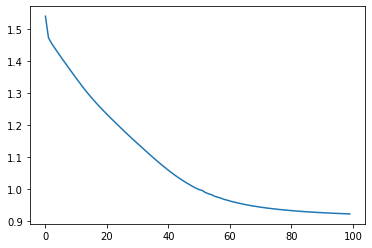

In [21]:
plt.plot(losses)
plt.show()

In [22]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [23]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.5630368e-03 2.2317676e-02 9.7543007e-01 4.1391281e-04 2.7526295e-04]
argmax를 한 후의 output은 2
accuracy는 0.9333333333333333


##Model 2 (0.95)

- activation function PReLU 사용


In [24]:
model = nn.Sequential(
          nn.Linear(4,398, bias=True),
          nn.PReLU(),
          nn.Linear(398,15, bias=True),
          nn.PReLU(),
          nn.Linear(15,5, bias=True), 
          nn.Softmax()
          ).to(device)

In [25]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4,398, bias=True), # input_layer = 4, hidden_layer1 = 398 
          nn.PReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.PReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.PReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [26]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [27]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): PReLU(num_parameters=1)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [28]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): PReLU(num_parameters=1)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [29]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.01)

# https://pytorch.org/docs/stable/optim.html#module-torch.optim 페이지 참조
# optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# sgd 등등

In [30]:
losses = []
for epoch in range(100):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.4713515043258667
10 0.9415695667266846
20 0.9247793555259705
30 0.9241472482681274
40 0.9239951968193054
50 0.9239258766174316
60 0.9238579273223877
70 0.92267906665802
80 0.9170045852661133
90 0.912156343460083


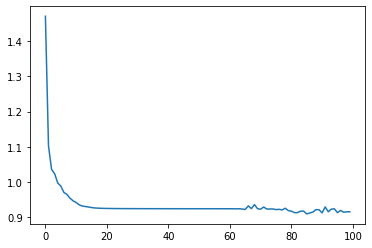

In [31]:
plt.plot(losses)
plt.show()

In [32]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [33]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [1.5725776e-24 1.9436202e-12 1.0000000e+00 1.9662800e-23 3.0969228e-23]
argmax를 한 후의 output은 2
accuracy는 0.9555555555555556


# Model 3 (0.97)
 - activation function: PReLU function
 - epoch 수 500으로 증가
 - lr 0.001로 감소 

In [35]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.001)

In [36]:
losses = []
for epoch in range(500):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5799660682678223
10 1.3300503492355347
20 1.24715256690979
30 1.2260724306106567
40 1.1597836017608643
50 1.1080377101898193
60 1.06008780002594
70 1.0077595710754395
80 0.9835731983184814
90 0.9685872197151184
100 0.9593635201454163
110 0.9533334374427795
120 0.9490780830383301
130 0.9459208250045776
140 0.943541407585144
150 0.9416739344596863
160 0.9401575922966003
170 0.9388955235481262
180 0.9378266334533691
190 0.9369081854820251
200 0.936108410358429
210 0.9354060292243958
220 0.9347816109657288
230 0.9342225790023804
240 0.9337180256843567
250 0.9332593083381653
260 0.9328386783599854
270 0.9324500560760498
280 0.9320880174636841
290 0.9317471981048584
300 0.9314232468605042
310 0.9311102032661438
320 0.9308024048805237
330 0.9304940104484558
340 0.9301761984825134
350 0.9298403859138489
360 0.9294776320457458
370 0.9289929866790771
380 0.928550660610199
390 0.9280972480773926
400 0.927642285823822
410 0.9272010922431946
420 0.9267703294754028
430 0.9263504147529602
440 0.9

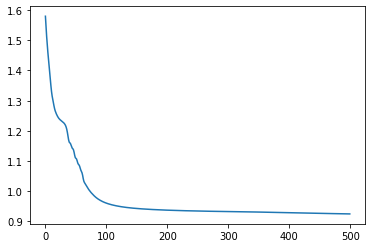

In [37]:
plt.plot(losses)
plt.show()

In [38]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [39]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [4.7405021e-15 5.4285829e-06 9.9999452e-01 4.8878557e-12 6.4089538e-09]
argmax를 한 후의 output은 2
accuracy는 0.9777777777777777


# Model 4 (0.82)
 - model 3에서 optimizer를 SGD로 변경

In [44]:
model = nn.Sequential(
          nn.Linear(4,398, bias=True),
          nn.PReLU(),
          nn.Linear(398,15, bias=True),
          nn.PReLU(),
          nn.Linear(15,5, bias=True), 
          nn.Softmax()
          ).to(device)

In [45]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4,398, bias=True), # input_layer = 4, hidden_layer1 = 398 
          nn.PReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.PReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.PReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output

In [46]:
def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)

In [47]:
model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): PReLU(num_parameters=1)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [48]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.SGD(model.parameters(), lr=0.001)

In [49]:
losses = []
for epoch in range(500):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.582080602645874
10 1.5375572443008423
20 1.5133548974990845
30 1.4963648319244385
40 1.4829946756362915
50 1.4704992771148682
60 1.4590332508087158
70 1.4489641189575195
80 1.439818263053894
90 1.4313668012619019
100 1.423706293106079
110 1.4168944358825684
120 1.4106837511062622
130 1.4047752618789673
140 1.399384617805481
150 1.394264817237854
160 1.3893743753433228
170 1.3844835758209229
180 1.3798270225524902
190 1.3753291368484497
200 1.3711011409759521
210 1.3669886589050293
220 1.3628554344177246
230 1.3588056564331055
240 1.354819655418396
250 1.3509713411331177
260 1.3472681045532227
270 1.3436352014541626
280 1.340090036392212
290 1.336596965789795
300 1.3332070112228394
310 1.3298438787460327
320 1.326493740081787
330 1.3231358528137207
340 1.319777011871338
350 1.3164018392562866
360 1.3129990100860596
370 1.3095588684082031
380 1.3060920238494873
390 1.3025404214859009
400 1.2988990545272827
410 1.295236349105835
420 1.291521668434143
430 1.287736177444458
440 1.283903

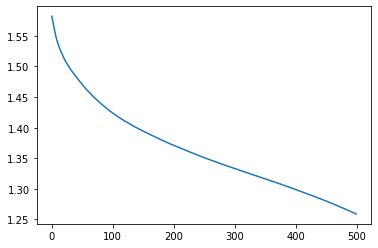

In [50]:
plt.plot(losses)
plt.show()

In [51]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [52]:
print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [0.0020377  0.13541158 0.62847906 0.03207119 0.2020005 ]
argmax를 한 후의 output은 2
accuracy는 0.8222222222222222


#Model 5 (0.88)

- model 3에서 epoch 수만 증가

In [63]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4,398, bias=True), # input_layer = 4, hidden_layer1 = 398 
          nn.PReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.PReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.PReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)


model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): PReLU(num_parameters=1)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [64]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.001)

losses = []
for epoch in range(1000):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.636629343032837
10 1.160982370376587
20 1.1039777994155884
30 1.0446466207504272
40 1.007040023803711
50 0.9802117943763733
60 0.9603386521339417
70 0.9447728395462036
80 0.9360098838806152
90 0.9314619302749634
100 0.9290887713432312
110 0.9277185797691345
120 0.9268689155578613
130 0.9263306260108948
140 0.9259411096572876
150 0.9256494641304016
160 0.9254206418991089
170 0.9252349138259888
180 0.9250836968421936
190 0.9249542355537415
200 0.9248484969139099
210 0.9247583746910095
220 0.9246789813041687
230 0.9246119856834412
240 0.9245513081550598
250 0.9244928359985352
260 0.9244456887245178
270 0.924403727054596
280 0.9243680834770203
290 0.9243355989456177
300 0.9243052005767822
310 0.9242772459983826
320 0.924252986907959
330 0.9242304563522339
340 0.9242101311683655
350 0.9241912961006165
360 0.9241740703582764
370 0.9241589307785034
380 0.924144446849823
390 0.9241312742233276
400 0.9241194725036621
410 0.92410808801651
420 0.9240977764129639
430 0.9240877628326416
440 0.9

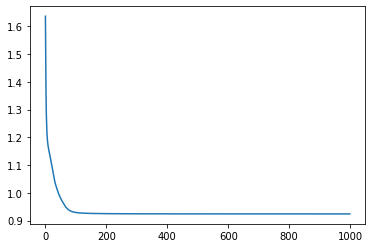

In [65]:
plt.plot(losses)
plt.show()

In [66]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [5.5490221e-25 3.5255940e-13 1.0000000e+00 2.9567672e-12 4.1244928e-14]
argmax를 한 후의 output은 2
accuracy는 0.8888888888888888


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)




#Model 6 (0.93)
 - model 3에서 drop out 진행



In [71]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4,398, bias=True), # input_layer = 4, hidden_layer1 = 398 
          nn.PReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.PReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.PReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

    self.dropout = nn.Dropout(0.25)

  def forward(self,x):
    output = self.layer1(x)
    output = self.dropout(output)
    output = self.layer2(output)
    output = self.dropout(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)


model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): PReLU(num_parameters=1)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
  (dropout): Dropout(p=0.25, inplace=False)
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [72]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.001)

losses = []
for epoch in range(500):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.6749732494354248
10 1.2047988176345825
20 1.1537549495697021
30 1.1183654069900513
40 1.0657817125320435
50 1.0157625675201416
60 0.9943544864654541
70 0.9694697260856628
80 0.9562732577323914
90 0.9462448358535767
100 0.9498337507247925
110 0.9375326037406921
120 0.9363527297973633
130 0.9315898418426514
140 0.9341423511505127
150 0.932036280632019
160 0.9265232086181641
170 0.9270665645599365
180 0.9513470530509949
190 0.946492075920105
200 0.9291418194770813
210 0.9253004789352417
220 0.9246399402618408
230 0.9217485785484314
240 0.9430835247039795
250 0.926564633846283
260 0.917999804019928
270 0.9318157434463501
280 0.9188389182090759
290 0.9197672009468079
300 0.9183528423309326
310 0.9228703379631042
320 0.9203697443008423
330 0.9251284599304199
340 0.9278420805931091
350 0.9146231412887573
360 0.9212952256202698
370 0.930497407913208
380 0.9231855869293213
390 0.923271119594574
400 0.9279970526695251
410 0.9109895825386047
420 0.9172993302345276
430 0.921819806098938
440 0.

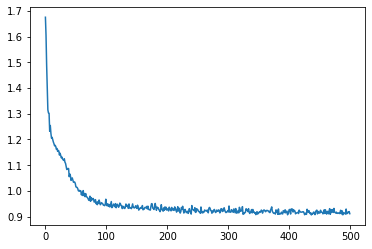

In [73]:
plt.plot(losses)
plt.show()

In [74]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [5.5700210e-24 1.2788211e-20 1.0000000e+00 2.4431474e-16 1.9020908e-19]
argmax를 한 후의 output은 2
accuracy는 0.9333333333333333


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


#Model 7 (0.93)
- model 3에서 뉴런 수 바꾸기

In [77]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4,64, bias=True),  
          nn.PReLU(),
        nn.BatchNorm1d(64)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(64,32, bias=True), 
        nn.PReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(32,16, bias=True),
        nn.PReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(16, 4, bias=True), 
        nn.Softmax()
    )


  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)


model = Model().to(device)
model.apply(init_weights)

print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): PReLU(num_parameters=1)
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer3): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): PReLU(num_parameters=1)
  )
  (layer4): Sequential(
    (0): Linear(in_features=16, out_features=4, bias=True)
    (1): Softmax(dim=None)
  )
)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [78]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.001)

losses = []
for epoch in range(500):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.2547762393951416
10 1.0757169723510742
20 0.9902662634849548
30 0.9236167073249817
40 0.8673364520072937
50 0.8296995759010315
60 0.805125892162323
70 0.7899764180183411
80 0.7811084389686584
90 0.7760996222496033
100 0.7728607058525085
110 0.7707395553588867
120 0.7692152261734009
130 0.7680596709251404
140 0.7671173214912415
150 0.7662079334259033
160 0.7645565271377563
170 0.7622134685516357
180 0.7583346366882324
190 0.7546460628509521
200 0.7533043026924133
210 0.7520301342010498
220 0.7511023879051208
230 0.7502921223640442
240 0.7495843172073364
250 0.7490012645721436
260 0.7484479546546936
270 0.747898519039154
280 0.7475117444992065
290 0.7470992803573608
300 0.7467117309570312
310 0.7464680075645447
320 0.746159017086029
330 0.7459414601325989
340 0.7457819581031799
350 0.7455823421478271
360 0.7454349994659424
370 0.7453151345252991
380 0.7452033162117004
390 0.7450970411300659
400 0.7449989914894104
410 0.744924783706665
420 0.7448120713233948
430 0.7447354197502136
440

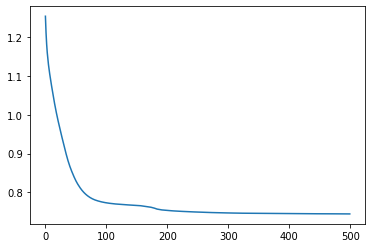

In [79]:
plt.plot(losses)
plt.show()

In [80]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [6.9185847e-16 4.0867214e-12 1.0000000e+00 1.5385629e-08]
argmax를 한 후의 output은 2
accuracy는 0.9333333333333333


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


#Model 8 (0.95)

 - activation function: LeakyReLU function
 - epoch 수 500으로 증가
 - lr 0.001로 감소 

In [59]:
class Model(torch.nn.Module):

  def __init__(self):
    super(Model, self).__init__()
    self.layer1 = nn.Sequential(
          nn.Linear(4,398, bias=True), # input_layer = 4, hidden_layer1 = 398 
          nn.LeakyReLU(),
        nn.BatchNorm1d(398)
    )

    self.layer2 = nn.Sequential(
          nn.Linear(398,15, bias=True), # hidden_layer1 = 398, hidden_layer2 = 15
        nn.LeakyReLU()
    )
    self.layer3 = nn.Sequential(
          nn.Linear(15,10, bias=True), # hidden_layer1 = 15, hidden_layer2 = 10
        nn.LeakyReLU()
    )
    self.layer4 = nn.Sequential(
        nn.Linear(10, 5, bias=True), # hidden_layer3 = 10, output_layer = 5
        nn.Softmax()
    )

  def forward(self,x):
    output = self.layer1(x)
    output = self.layer2(output)
    output = self.layer3(output)
    output = self.layer4(output)
    return output


def init_weights(layer):
    if isinstance(layer, nn.Linear):
        torch.nn.init.xavier_uniform(layer.weight)
        layer.bias.data.fill_(0.01)


model = Model().to(device)
model.apply(init_weights)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:34: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)

In [54]:
print(model)

Model(
  (layer1): Sequential(
    (0): Linear(in_features=4, out_features=398, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): BatchNorm1d(398, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Linear(in_features=398, out_features=15, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer3): Sequential(
    (0): Linear(in_features=15, out_features=10, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
  )
  (layer4): Sequential(
    (0): Linear(in_features=10, out_features=5, bias=True)
    (1): Softmax(dim=None)
  )
)


In [55]:
loss_fn  = nn.CrossEntropyLoss().to(device)

optimizer = optim.Adam(model.parameters(), lr= 0.001)

losses = []
for epoch in range(500):

  optimizer.zero_grad()
  hypothesis = model(x_train)

  # 비용 함수
  cost = loss_fn(hypothesis, y_train)
  cost.backward()
  optimizer.step()
  losses.append(cost.item())

  if epoch % 10 == 0:
    print(epoch, cost.item())

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0 1.5698903799057007
10 1.26022469997406
20 1.1332345008850098
30 1.0353803634643555
40 0.9740350842475891
50 0.9470389485359192
60 0.9347701072692871
70 0.926617443561554
80 0.9207988381385803
90 0.9172896146774292
100 0.9146406054496765
110 0.9125564694404602
120 0.9110458493232727
130 0.9100550413131714
140 0.90925532579422
150 0.9085433483123779
160 0.9079495668411255
170 0.9075399041175842
180 0.9071894288063049
190 0.9068893194198608
200 0.9066641926765442
210 0.9064570665359497
220 0.906284511089325
230 0.906122624874115
240 0.9060031771659851
250 0.9059170484542847
260 0.9058100581169128
270 0.9057391881942749
280 0.9056661128997803
290 0.9056039452552795
300 0.9055312871932983
310 0.9054939150810242
320 0.9054345488548279
330 0.9053943157196045
340 0.9053619503974915
350 0.9053258299827576
360 0.905289888381958
370 0.905264139175415
380 0.9052431583404541
390 0.9052169322967529
400 0.9051982164382935
410 0.9051778316497803
420 0.9051610827445984
430 0.9051494598388672
440 0.90

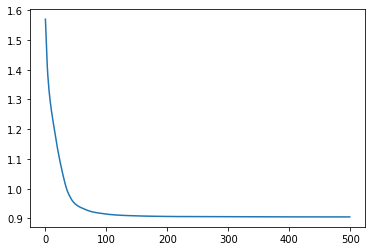

In [56]:
plt.plot(losses)
plt.show()

In [57]:
with torch.no_grad():
  model = model.to('cpu')
  y_pred = model(x_test)
  y_pred = y_pred.detach().numpy()
  predicted = np.argmax(y_pred, axis =1)
  accuracy = (accuracy_score(predicted, y_test))

print(f'model의 output은 :  {y_pred[0]}')
print(f'argmax를 한 후의 output은 {predicted[0]}')
print(f'accuracy는 {accuracy}')

model의 output은 :  [8.054707e-10 1.238313e-13 1.000000e+00 8.590539e-15 2.355070e-09]
argmax를 한 후의 output은 2
accuracy는 0.9555555555555556


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


#Model 3 - PReLU function, epoch 500, lr 0.001이 0.97로 가장 좋은 성능
